In [ ]:
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 15.1 MB/s eta 0:00:00


In [ ]:
import torchvision
import torch
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from torchsummary import summary
import tqdm
from IPython.display import clear_output
import sys

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
!unzip MNIST_CSV.zip

## Data Pre-Processing

In [ ]:
train_set = pd.read_csv("mnist_train.csv")
test_images = pd.read_csv("mnist_test.csv")

train_images, val_images, train_labels, val_labels = train_test_split(train_set.iloc[:, 1:],
                                                                     train_set.iloc[:, 0],
                                                                     test_size=0.2)

train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

train_images = train_images.to_numpy(dtype='float32')
train_labels = train_labels.to_numpy(dtype='float32')

val_images = val_images.to_numpy()
val_labels = val_labels.to_numpy()

test_images = test_images.to_numpy()

## Dataset

In [ ]:
class JigsawDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, permutations=10, img_transformer=None):
        self.images = images
        self.labels = labels
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_tiles(self, index):
        img = self.__get_image(index).reshape(28, 28)
        tiles = np.zeros((9, 9, 9), dtype='float32')

        for i in range(3):
            for j in range(3):
                tiles[i * 3 + j] = img[i*9:i*9+9, j*9:j*9+9]

        return tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        tiles = self.__get_tiles(index)

        order = self.__retrieve_permutations()

        data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]

        item = torch.stack(data, 0)
        return item, order, int(self.labels[index])

    def __len__(self):
        return self.N

In [ ]:
class JigsawDatasetTest(torch.utils.data.Dataset):
    def __init__(self, images, permutations=10, img_transformer=None):
        self.images = images
        self.permutations = permutations

        self.N = len(self.images)
        self.grid_size = 3

    def __retrieve_permutations(self):
        nums = range(self.grid_size * self.grid_size)

        return np.random.permutation(nums)

    def __get_image(self, index):
        return self.images[index]

    def __get_tiles(self, index):
        img = self.__get_image(index).reshape(28, 28)
        tiles = np.zeros((9, 9, 9), dtype='float32')

        for i in range(3):
            for j in range(3):
                tiles[i * 3 + j] = img[i*9:i*9+9, j*9:j*9+9]

        return tiles

    def __getitem__(self, index):
        n_grids = self.grid_size ** 2
        tiles = self.__get_tiles(index)

        order = self.__retrieve_permutations()

        data = [torch.from_numpy(tiles[order[t]]) for t in range(n_grids)]

        item = torch.stack(data, 0)
        return item, order

    def __len__(self):
        return self.N

## Dataloaders

In [ ]:
train_data = JigsawDataset(train_images, train_labels)
val_data = JigsawDataset(val_images, val_labels)
test_data = JigsawDatasetTest(test_images)

train_loader = torch.utils.data.DataLoader(
        dataset     = train_data,
        num_workers = 2,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = True,
)

val_loader = torch.utils.data.DataLoader(
        dataset     = val_data,
        num_workers = 1,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = False,
    )

test_loader = torch.utils.data.DataLoader(
        dataset     = test_data,
        num_workers = 1,
        batch_size  = 1,
        pin_memory  = True,
        shuffle     = False,
    )

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Train dataset samples = 47999, batches = 47999
Val dataset samples = 12000, batches = 12000
Test dataset samples = 9999, batches = 9999


## State

Class represents current state of Jigsaw board

In [ ]:
class State:
    def __init__(self, tiles, current_shuffle_list):
        self.tiles = tiles
        self.current_shuffle_list = current_shuffle_list

        legal_actions = []

        for i in range(9):
            for j in range(9):
                if i != j:
                    legal_actions.append((i, j))
        self.legal_actions = legal_actions

        num_incorrect = 9 - self.num_correct()
        print(f"Initial incorrect: {num_incorrect}")

    def get_legal_actions(self):
        return self.legal_actions

    def num_correct(self):
      count = 0
      for i in range(9):
        if i == self.current_shuffle_list[0][i]:
          count += 1

      return count
    def is_game_over(self):
        for i in range(9):
            if i != self.current_shuffle_list[0][i]:
                return False

        return True

    def move(self, action):
        i, j = action
        self.tiles[0][i], self.tiles[0][j] = self.tiles[0][j].clone(), self.tiles[0][i].clone()

        self.current_shuffle_list[0][i], self.current_shuffle_list[0][j] = self.current_shuffle_list[0][j].item(), self.current_shuffle_list[0][i].item()

        return self

In [ ]:
class JigsawEnv():

    def __init__(self, tiles, current_shuffle_list):
        self.state = State(tiles, current_shuffle_list)
        self.num_incorrect = 9 - self.state.num_correct()

        self.actions = []

        for i in range(8, 0, -1): # bc 0-8 is 9 numbers
          for j in range(i):
            self.actions.append((i,j))

    """
    Compute Reward for the current state.

    Parameters:
    - None

    Returns:
    - reward (float): amount of reward returned after previous action
    """

    def computeReward(self):
        reward = 0

        # Reward is normalized in end
        if self.state.is_game_over():
            reward += 100
        else:
            for i in range(9):
                if self.state.current_shuffle_list[0][i] == i:
                    reward += 1

        return reward


    """
    Step the environment by one timestep.

    Parameters:
    - action

    Returns:
    - observation (object): agent's observation of the current environment
    - reward (float) : amount of reward returned after previous action
    - done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
    - info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)

    """
    def step(self, action):
        observation = self.state.move(action)
        reward =  self.computeReward()

        return observation, reward, self.state.is_game_over()

    """
    Renders the environment.
    """
    def render(self):
        fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6,6))
        fig.subplots_adjust(hspace=.1)
        for i in range(3):
            for j in range(3):
                ax[i][j].axis('off')
                ax[i][j].imshow(self.state.tiles[(self.state.order==i * 3 + j).nonzero(as_tuple=True)[0].item()], cmap='gray')

In [ ]:
"""
Update the policy network using the policy gradient theorem.

Parameters:
- policy_network (nn.Module): policy network to be updated
- rewards (list): list of rewards from the most recent episode
- log_probs (list): list of log probabilities from the most recent episode
- GAMMA (float): discount factor

Returns:
- None
"""
def update_policy(policy_network, rewards, log_probs, GAMMA):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)

    # Handles Normalization edge case where only 1 move is made
    # Hence no normalization is needed
    if len(rewards) == 1:
      discounted_rewards = torch.tensor([1.0])
    else:
      discounted_rewards = torch.tensor(discounted_rewards)
      discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    # Math is found by policy gradient theorem
    # Refer to REINFORCE paper for more details
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)

    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward(retain_graph=True)
    torch.nn.utils.clip_grad_norm_(policy_network.parameters(), max_norm=1, norm_type=2.0)
    policy_network.optimizer.step()

    return

In [ ]:
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, num_actions=36, lr=1e-3):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 16, kernel_size=9, stride=9)
        self.bn3 = nn.BatchNorm2d(16)

        self.linear1 = nn.Linear(144, 64)
        self.linear2 = nn.Linear(64, 36)

        self.activation = nn.SiLU()

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, state):
        out = self.assemble(state).to(DEVICE)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.activation(out)


        out = self.conv2(out)
        out = self.bn2(out)
        out = self.activation(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.activation(out)

        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        out = self.activation(out)

        out = self.linear2(out)
        out = F.softmax(out, dim=1)
        return out

    """
    assemble the 3x3 stack of images into a 1x27x27 image

    Step the environment by one timestep.

    Parameters:
    - state (object): 3x3 stack of images

    Returns:
    - result_image (object): 1x27x27 image

    """

    def assemble(self, state):
      result_image = torch.zeros(1, 1, 27, 27)

      for i in range(9):
          row = i // 3  # Calculate the row index in the 3x3 grid
          col = i % 3   # Calculate the column index in the 3x3 grid

          # Calculate the starting position to place the image in the result tensor
          start_row = row * 9
          start_col = col * 9

          # Assign the 9x9 image to the correct position in the result tensor
          result_image[:, :, start_row:start_row + 9, start_col:start_col + 9] = state[:, 3*row+col, :, :]

      return result_image

    """
    get the action probabilities of the policy network

    Parameters:
    - state (object): 3x3 stack of images

    Returns:
    - probs (object): 1x36 vector of action probabilities

    """

    def get_action(self, state):
        probs = self.forward(Variable(state))
        probs = probs[0]
        probs = probs.cpu()
        return probs

In [ ]:
import wandb
wandb.login(key="ARBITRARY_KEY")

In [ ]:
config = {
    'max_steps': 50,
    'GAMMA': 0.9,
    'lr': 1e-3,
    'epochs': 10
}

In [ ]:
run = wandb.init(
    name = "16-32, 144-64-32, kernel sizes 3, 9, scaling reward, SiLU, 3 conv layers", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    project = "Policy Network Tuning", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

In [ ]:
def save_model(model, reward, epoch):
  torch.save({'model_state_dict':model.state_dict(),
              'optimizer_state_dict':model.optimizer.state_dict(),
              'valid_dist': reward,
              'epoch': epoch}, f'./checkpoint-{epoch}.pth')

In [ ]:
policy_net = PolicyNetwork().to(DEVICE)

In [ ]:
max_steps = config['max_steps']
numsteps = []
avg_numsteps = []
all_rewards = []
successes = []

for epoch in range(config['epochs']):
    for episode, (tiles, order, _) in enumerate(train_loader):
        env = JigsawEnv(tiles, order)
        state = env.state
        log_probs = []
        rewards = []
        successes = []

        for steps in range(config['max_steps']):
            probs = policy_net.get_action(state.tiles)
            highest_prob_action = np.random.choice(policy_net.num_actions, p=np.squeeze(probs.detach().numpy()))
            log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
            action = env.actions[highest_prob_action]
            new_state, reward, done = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done or steps == max_steps - 1:
                if done:
                  successes.append(1)
                else:
                  successes.append(0)
                update_policy(policy_net, rewards, log_probs, GAMMA=config['GAMMA'])
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))

                break
            state = new_state

        # Log metrics to WandB
        if episode % 500 == 0:
            curr_lr = float(policy_net.optimizer.param_groups[0]['lr'])
            avg_reward = np.mean(all_rewards[-500:])
            wandb.log(
                {
                    "total_reward": np.sum(rewards),
                    "avg_reward": avg_reward, # fix thus to include past 500 timesteps
                    "success %": np.mean(successes),
                    "length": steps, # why is this using steps?
                    'lr': curr_lr
                }
            )
            successes = []
            save_model(policy_net, avg_reward, epoch)

    curr_lr = float(policy_net.optimizer.param_groups[0]['lr'])

    policy_net.optimizer = optim.Adam(policy_net.parameters(), lr=curr_lr * 0.5)

    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.xlabel('Episode')
    plt.show()

run.finish()

Initial incorrect: 9
episode: 0, total reward: 295, average_reward: 295.0, length: 43


NameError: ignored

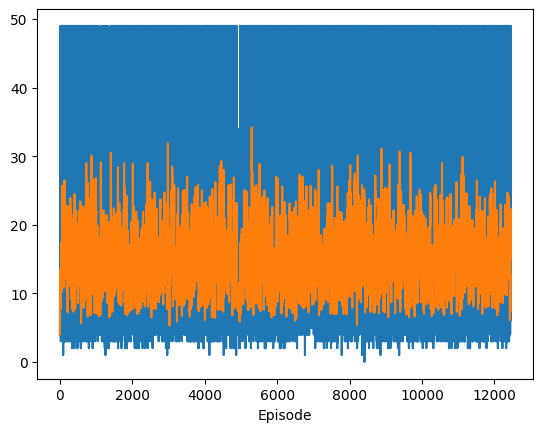

In [ ]:
plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.show()

## Preliminary Test

In [ ]:
"""
METRICS

16.97069450020072
Percent success: 65.0%

17.19759206798867
Percent success: 65.02000000000001%
"""

numsteps.remove(49)

res = [i for i in numsteps if i != 49]
print(np.mean(res))

failed = numsteps[-5000:].count(49)

print(f"Percent success: {100 - (failed / 5000) * 100}%")



10.505107624954396
Percent success: 87.86%


## Validation Metrics

In [ ]:
policy_net = PolicyNetwork().to(DEVICE)
dict1 = torch.load('FINAL.pth')
policy_net.load_state_dict(dict1['model_state_dict'])

config['max_steps'] = 50
max_steps = config['max_steps']
numsteps = []
avg_numsteps = []
all_rewards = []
successes = []

for episode, (tiles, order, _) in enumerate(val_loader):
    env = JigsawEnv(tiles, order)
    state = env.state
    log_probs = []
    rewards = []

    for steps in range(config['max_steps']):
        probs = policy_net.get_action(state.tiles)
        highest_prob_action = np.random.choice(policy_net.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        action = env.actions[highest_prob_action]
        new_state, reward, done = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done or steps == max_steps - 1:
            if done:
              successes.append(1)
            else:
              successes.append(0)
            # update_policy(policy_net, rewards, log_probs, GAMMA=config['GAMMA'])
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            sys.stdout.write("Sucess: {}, episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(done, episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break

        state = new_state

    # Log metrics to WandB
    if episode % 500 == 0:
        avg_reward = np.mean(all_rewards[-500:])


plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.show()

Initial incorrect: 9
tensor([0.0582, 0.0300, 0.0265, 0.0406, 0.0264, 0.0245, 0.0366, 0.0306, 0.0275,
        0.0470, 0.0260, 0.0291, 0.0257, 0.0128, 0.0197, 0.0096, 0.0383, 0.0162,
        0.0071, 0.0383, 0.0060, 0.0236, 0.0069, 0.0318, 0.0051, 0.0045, 0.0313,
        0.0237, 0.1055, 0.0363, 0.0424, 0.0197, 0.0105, 0.0339, 0.0196, 0.0284],
       grad_fn=<ToCopyBackward0>)
tensor([0.0582, 0.0300, 0.0265, 0.0406, 0.0264, 0.0245, 0.0366, 0.0306, 0.0275,
        0.0470, 0.0260, 0.0291, 0.0257, 0.0128, 0.0197, 0.0096, 0.0383, 0.0162,
        0.0071, 0.0383, 0.0060, 0.0236, 0.0069, 0.0318, 0.0051, 0.0045, 0.0313,
        0.0237, 0.1055, 0.0363, 0.0424, 0.0197, 0.0105, 0.0339, 0.0196, 0.0284],
       grad_fn=<ToCopyBackward0>)
tensor([2.6771e-03, 1.0502e-03, 1.0610e-03, 4.3286e-04, 6.2205e-06, 5.5100e-05,
        6.3675e-04, 9.8103e-04, 3.0863e-02, 8.5304e-01, 3.3241e-04, 9.6933e-03,
        3.9732e-04, 2.9439e-03, 2.3069e-03, 2.0183e-05, 1.3360e-02, 6.5500e-05,
        3.7231e-03, 4.4984e-0

KeyboardInterrupt: ignored

In [ ]:
"""
METRICS
"""

res = [i for i in numsteps if i != config['max_steps']]
print(f"Mean Steps: {np.mean(res)}")

print(f"Percent success:{np.mean(successes) * 100}%")

Mean Steps: 13.661971830985916
Percent success:92.95774647887323%


## Metrics
Mean Steps: 13.661971830985916

Percent success: 92.95774647887323%